# 解决房屋价格预测

In [ ]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.utils import data
from torch.nn import functional as F
import matplotlib.pyplot as plt

# 数据导入

In [ ]:
"""
导入数据
"""
df_train = pd.read_csv('D:\project\HousePrice\\train.csv')
df_test = pd.read_csv('D:\project\HousePrice\\test.csv')
ID =df_test.iloc[:,0]
all_data = pd.concat([df_train.iloc[:,1:-1],df_test.iloc[:,1:]],axis=0)
all_data.iloc[:,0] = all_data.iloc[:,0].astype(str)
all_data.info()


# 数据清洗

## 归一化
$$ X = \frac{x-\mu}{\sigma} ,\mu为均值，\sigma为标准差$$

In [ ]:
numindex = all_data.dtypes[all_data.dtypes != 'object'].index
y = all_data[numindex]
y = (y-y.mean())/y.std()
all_data[numindex] = y
all_data[numindex] = all_data[numindex].fillna(0)

## 独热编码转化

In [ ]:
def get_onehot(col):
    """
    函数用于将一个DataFrame中的一列数据转化为onehot编码
    :param col: DataFrame中所需的一列数据
    :return: onehot编码过后的Tensor对象
    """
    dic ={}
    p = []
    lis = col.value_counts().index
    for i in range(lis.shape[0]):
        dic[lis[i][0]] = i
    print(dic)
    for i in range(col.shape[0]):
        m = col.iloc[i].values[0]
        p.append(dic[m])
    p = torch.tensor(p)
    return F.one_hot(p)

In [ ]:
all_data = pd.get_dummies(all_data,dummy_na=True,dtype=np.int8)
train_num =df_train.shape[0]
x_train = torch.tensor(all_data[:train_num].values,dtype=torch.float)
x_test = torch.tensor(all_data.iloc[train_num:,:].values,dtype=torch.float)
y_train =torch.tensor(df_train.iloc[:,-1].values,dtype=torch.float).reshape((-1,1))

# 设置迭代器

In [ ]:
def data_iter(arg,batch_size):
    P = data.TensorDataset(*arg)
    return data.DataLoader(P,batch_size)

# 设置损失函数
$$\rm L = loss= \sum_{i=1}^n (y_i-\widehat y_{i})^2 $$
$$logloss = \sqrt[]{\frac{\sum_{i=1}^n (lny_i-ln\widehat y_i)^2}{n}} $$

In [ ]:
loss = nn.MSELoss()

In [33]:
def log_rmse(net,x,y):
    """
    用于输出log损失
    :param net: 对应网络模型
    :param x: feature
    :param y: label
    :return:
    """
    clipped_preds = torch.clamp(net(x),1,float('inf'))
    rmse = torch.sqrt(loss(torch.log(clipped_preds),torch.log(y)))
    return rmse.item()

# 定义net
此处我们用两种方式定义模型

In [ ]:
class MyNet(nn.Module):
    def __init__(self,num_input,num_output,num_hidden1,num_hidden2,is_training=True):
        super(MyNet,self).__init__()
        self.num_input = num_input
        self.training = is_training
        self.Lin1 = nn.Linear(num_input,num_hidden1)
        self.Lin2 = nn.Linear(num_hidden1,num_hidden2)
        self.Lin3 = nn.Linear(num_hidden2,num_output)
        self.relu = nn.ReLU()

    def forward(self,x):
        o1 = self.relu(self.Lin1(x))
        o2 = self.relu(self.Lin2(o1))
        o3 = self.Lin3(o2)
        return o3

In [ ]:
def get_net():
    net = nn.Sequential(
        nn.Linear(346,1500),
        nn.Sigmoid(),
        nn.Dropout(0.5),
        nn.Linear(1500,500),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(500,1),
    )
    return net.to('cuda')

# 定义训练模式

In [36]:
def train(net,x_train,y_train,x_test,y_test,epochs,lr,w_decay,batch_size):
    """
    函数用于定义训练过程
    :param net: net模型
    :param x_train: 用于训练的feature
    :param y_train: 用于训练的label
    :param x_test: 用于测试的feature
    :param y_test: 用于测试的label
    :param epochs: 训练次数
    :param lr: 学习率
    :param w_decay: 权重损失率
    :param batch_size: 每次从测试集中抽出的数量
    :return: 两个损失列表，用于记录每次epoch中训练集与验证集的损失（此处选取log损失）
    """
    train_ls,test_ls = [],[]
    opt = torch.optim.Adam(net.parameters(),lr=lr,weight_decay=w_decay)
    for epoch in range(epochs):
        net.train()
        for x,y in data_iter((x_train,y_train),batch_size):
            opt.zero_grad()
            x = x.to('cuda')
            y = y.to('cuda')
            y_hat = net(x)
            l = loss(y_hat,y)
            l.backward()
            opt.step()
        net.eval()
        with torch.no_grad():
            # 将模型临时转到CPU计算损失
            net_cpu = net.to('cpu')
            train_loss = log_rmse(net_cpu, x_train, y_train)
            if test_ls is not None:
                test_loss = log_rmse(net_cpu, x_test, y_test)
            # 将模型转回原来的设备
            net = net.to('cuda')
            
            train_ls.append(train_loss)
            if test_ls is not None:
                test_ls.append(test_loss)
    return train_ls,test_ls

# K折交叉验证

In [ ]:
def K_data(k,i,x,y):
    """
    利用K折交叉验证返回第i折的数据
    :param k: k折
    :param i: 需要返回的第i折
    :param x: 数据集feature
    :param y: label
    :return:
    """
    assert k>1
    f_size = x.shape[0]//k
    x_train,y_train = None,None
    for j in range(k):
        idx = slice(j*f_size,(j+1)*f_size)
        x_part,y_part = x[idx,:],y[idx]
        if j == i:
            x_valid,y_valid = x_part,y_part
        elif x_train is None:
            x_train,y_train = x_part,y_part
        else:
            x_train = torch.cat(([x_train,x_part]),0)
            y_train = torch.cat(([y_train,y_part]),0)
    return x_train,y_train,x_valid,y_valid

# 开始训练

In [37]:
def get_train(x,y,k,epochs,batch_size,lr,wd):
    """
    开始训练
    :param x: 训练集feature
    :param y: 训练集label
    :param k: k折数
    :param epochs: 训练次数
    :param batch_size: 小批量数
    :param lr: 学习率
    :param wd: 权重损失率
    :return: 一个列表用于记录每折的net
    """
    NET=[]
    for i in range(k):
        plt.figure(i+1)
        Data = K_data(k,i,x,y)
        net = MyNet(346,1,500,500)
        net = net.to(device='cuda')
        train_ls,test_ls = train(net,*Data,epochs=epochs,lr=lr,w_decay=wd,batch_size=batch_size)
        print(f'第{i+1}折:',f'训练损失：{train_ls[-1]}',f'测试损失{test_ls[-1]}')
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.yscale('log')
        plt.plot(train_ls,label='train',color='r')
        plt.plot(test_ls,label='test',color='blue')
        plt.show()
        NET.append(net)

    return NET

第1折: 训练损失：0.1382696032524109 测试损失0.15110991895198822


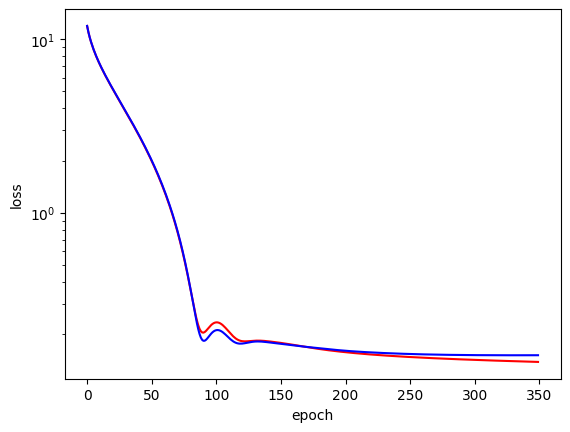

第2折: 训练损失：0.1374746710062027 测试损失0.1563866138458252


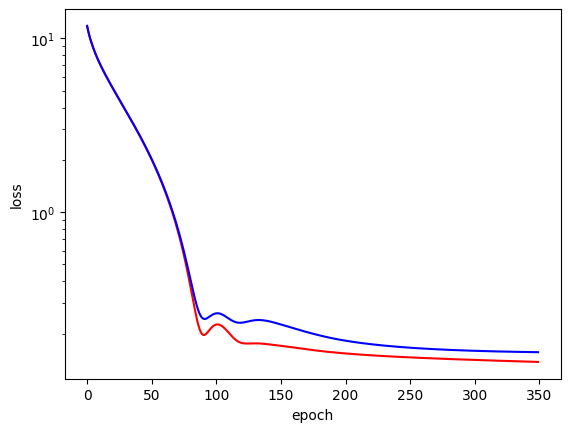

第3折: 训练损失：0.1346609890460968 测试损失0.14368560910224915


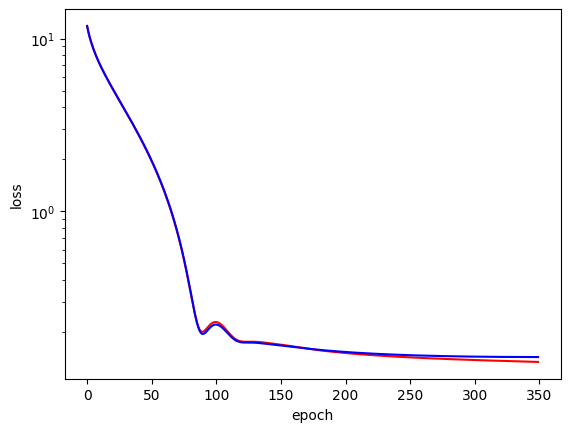

第4折: 训练损失：0.1400725096464157 测试损失0.14697152376174927


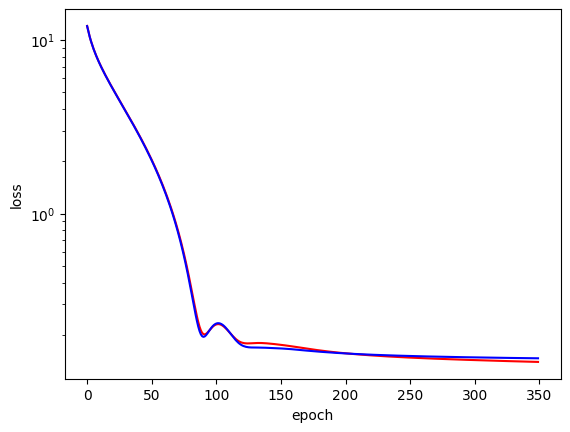

第5折: 训练损失：0.13177244365215302 测试损失0.17507436871528625


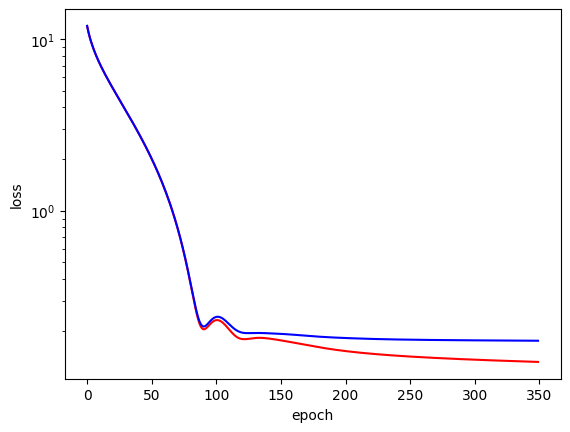

In [42]:
"""
定义超参数
"""
lr = 0.0025
epochs = 350
batch_size =2512
k = 5
wd = 3




"""
开始训练
"""
NET = get_train(x_train,y_train,k,epochs,batch_size,lr,wd)

In [45]:
net = NET[2] #结合图像选择训练效果最好的net
net = net.to(device='cpu')
net(x_train).detach()
y_test = net(x_test).detach().numpy()
pre = pd.DataFrame(y_test,columns=['SalePrice'])
ans = pd.concat([ID,pre],axis=1)
ans.to_csv('submission.csv',index=False)